# CISL paper
https://www.image.ucar.edu/staff/rnair/cisl_mwr.pdf

In [367]:
import numpy as np
import matplotlib.pyplot as plt


class CISLgrid(object):
    def __init__(self, n):
        self.n = n
        self.x = np.linspace(0,1,n+1)[:-1]
        self.dx = 1/n
        self.cells = np.linspace(self.dx/2, 1 + self.dx/2,n+1)[:-1]
        
    def plot(self, y, figsize=(12,5)):
        fig = plt.figure(figsize=figsize)
        
        plt.plot(self.cells, y)
        
        plt.scatter(self.cells, y, marker='+',c='r')
        
        plt.axhline(0,c='orange',alpha=0.15)
        plt.scatter(self.cells, y*0, marker='+',c='orange',label='cells centers')
        for val in self.x : plt.axvline(val,c='k',alpha=.3,label='cell walls' if val==0 else None) 
        plt.legend();
        return fig;
        
        
    def ppm_coeffs(self, y):
        hL = (y + np.roll(y, 1))/2
        hR = np.roll(hL, -1)
        
        dh = hR - hL
        hS = 6*y-3*(hL+hR)
        return dh, hS
    
    def ppm_eval(self, y, sub_div=5):    
        dh, hS = self.ppm_coeffs(y)
        
        xs = np.linspace(-.5,.5, sub_div)[:-1]
        
        xs = np.array([xs])
        dh = np.array([dh])
        hS = np.array([hS])
        
        ppm = y[:,np.newaxis] + dh.T @ xs + hS.T @ (1/12 - xs**2)
        ppm = np.ndarray.flatten(ppm)
        
        xs = np.linspace(0,1, self.n * (sub_div-1) + 1) [:-1]
        return xs, ppm
        
        
    def plot_ppm(self, y, sub_div=5, figsize=(12,5)):
        fig = self.plot(y,figsize=figsize)
        xs, ppm = self.ppm_eval(y, sub_div)
        plt.plot(xs, ppm, c='g',label='PPM')
        plt.legend();
        return fig;
        
    def backtrack(self, wind, dt):
        eulerian_walls = self.x
        check = eulerian_walls - dt*wind
        origin_walls = (eulerian_walls - dt*wind) % 1.0
        return eulerian_walls, origin_walls, check
    
    def plot_backtrack(self, wind, dt,figsize=(12,5),sub=1):
        eulerian_walls, origin_walls, check = self.backtrack(wind,dt)
        print('walls crossing check :', not all((np.roll(check,-1) - check)[:-1]>0))
        fig = plt.figure(figsize=figsize)
        
        for val in self.x[::sub] : plt.axvline(val,c='r',alpha=.8,linewidth=1.5,label='eulerian walls' if val==0 else None) 
        for i,val in enumerate(origin_walls[::sub]) : plt.axvline(val,c='r',alpha=.35,label='origin walls' if i==0 else None)
        plt.plot(list(self.x) + [1], list(wind) + [wind[0]], label='wind field',c='royalblue',alpha=0.8)
        plt.legend(loc='upper right');
        plt.xlabel(r'$\mathbf{x}$',fontsize=15);plt.ylabel(r'$u(\mathbf{x})$',fontsize=15)
        return fig;
    
    def remap(self, y, wind, dt):
        origin_walls = self.backtrack(wind,dt)[1]
        out = self.cells_integrations(origin_walls,y)
        return out
    
    def cells_integrations(self, origin_walls, y):
        
        left_walls = origin_walls
        right_walls = np.roll(origin_walls, -1)
        
        ppm_coeffs = self.ppm_coeffs(y)
        
        cells_integrations = self.n*np.array([self.cell_integrator(ppm_coeffs, lw, rw, y) for (lw,rw) in zip(left_walls,right_walls)])
        
        return cells_integrations
    
    def cell_integrator(self, ppm_coeffs, lw, rw, y):
        '''
        returns the analytical integration of the parabolic piecewise (of coefficients ppm_coeffs) of y,
        between x = a and x = b, 
        
        Method : 
        - compute the int_a_b = int_0_b - int_0_a (0 is the refererence line)
        - int
        '''
        eps = 0.75
        if abs(lw-rw) > eps:
#             print(lw,rw)
            if rw < lw :
                return self.integrate(rw,y,ppm_coeffs) + (y.sum()*self.dx - self.integrate(lw,y,ppm_coeffs))
            else :
                print('warning')
                return 0
        else :
            return self.integrate(rw,y,ppm_coeffs)  - self.integrate(lw,y,ppm_coeffs)
        
    
    def integrate(self, c, y, ppm_coeffs):
        dh, hS = ppm_coeffs
        
        ic = int(c // self.dx)
        c = (c - self.x[ic])/self.dx - 0.5
        
        plain_cells = y[:ic].sum() * self.dx
        analyitical_last_cell = ( (c+0.5)*(y[ic] + hS[ic]/12) + dh[ic]*(c**2-.25)*.5 + hS[ic]*(-1/8 - c**3)/3 ) * self.dx
        val =  plain_cells + analyitical_last_cell
        val = max(val,0) # cutting negative concentrations 
        return val
        
        

## Piecewise Parabolic Method

TOTAL MASS
  y : 2.0 
  PPM interpolation : 2.0


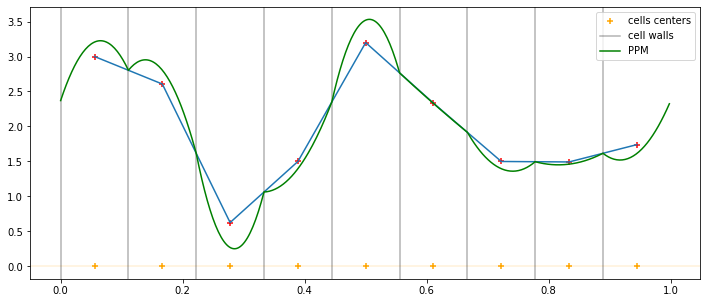

In [368]:
n = 9
grid = CISLgrid(n)

y = 2 + np.cos(4*np.pi*grid.x) + 0.5*np.sin(6*np.pi*grid.x)

xs, out = grid.ppm_eval(y)
grid.plot_ppm(y,sub_div=50);

print('TOTAL MASS\n  y :',y.mean(),'\n  PPM interpolation :',out.mean())

## backtracking walls

walls crossing check : False


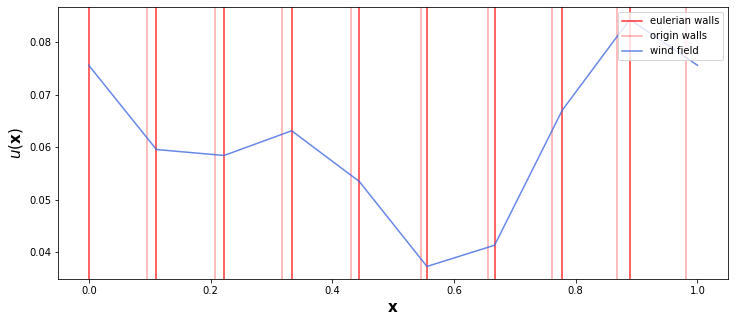

In [377]:
D = 1000
wind = (1 + 0.26*np.cos(2*np.pi*grid.x) - 0.21*np.sin(4*np.pi*grid.x)) * 60 /D

dt = 0.25
grid = CISL_transport(dt, wind)

grid.plot_backtrack(wind,dt);

## Transport model

In [375]:
import sys
sys.path.append('../')
from model.model import Model

class CISL_transport(Model, CISLgrid):
    def __init__(self, dt, wind):
        self.dt = dt
        self.wind = wind
        self.n = len(wind)
        CISLgrid.__init__(self, self.n)
        
        
    def _step(self, x, t, new_dt=None):
        dt_ = new_dt if new_dt else self.dt
        x = self.remap(x, self.wind, dt_)
        t += dt_
        return x,t

## 24h forecast

100%|██████████| 96/96 [00:00<00:00, 407.33it/s]


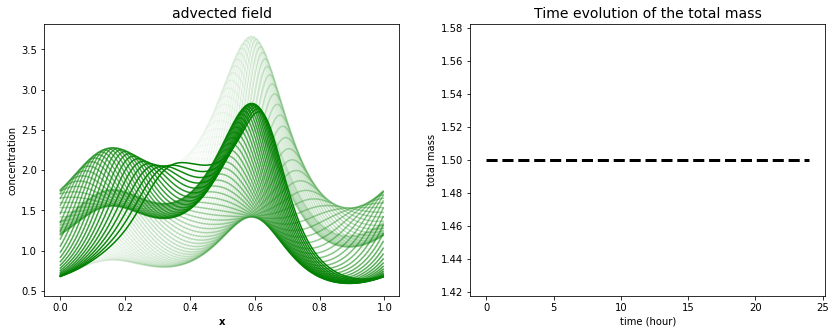

In [400]:
n = 241
grid = CISLgrid(n)

D = 1000
wind = (1 + 0.26*np.cos(2*np.pi*grid.x) - 0.21*np.sin(4*np.pi*grid.x)) * 60 /D

dt = 0.25
mod = CISL_transport(dt, wind)

t_end =  24
y = 1.5 + 0.2 * np.cos(4*np.pi*grid.x) + 0.2*np.sin(2*np.pi*grid.x)

forecast = mod.forecast(y, t_end,time_saving_interval=dt)

times, steps = list(forecast.keys()), np.array(list(forecast.values()))

fig, ax = plt.subplots(1,2,figsize=(14,5))
for t, val in forecast.items():
    ax[0].plot(mod.x, val, c='g', alpha=(t/t_end)**3)
ax[0].set_title("advected field",fontsize=14)    
ax[0].set_xlabel(r'$\mathbf{x}$'); ax[0].set_ylabel('concentration'); 

ax[1].plot(times, steps.mean(axis=1),c='k',linewidth=3,linestyle='--')
ax[1].set_title('Time evolution of the total mass',fontsize=14);
ax[1].set_xlabel('time (hour)'); ax[1].set_ylabel('total mass'); 

## the CISL scheme allows us to use the semi-lagrangian method while being mass conservative ! 